In [1]:
from importlib import reload
import sys
import os
sys.path.insert(0, './../scripts')

In [2]:
import pickle
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.figure import figaspect
import time

import spat_ori_network as network
import sim_util as su
import ricciardi as ric
import integrate as integ

def imshowbar(fig,ax,A,**kwargs):
    imsh = ax.imshow(A,**kwargs)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(imsh, cax=cax, orientation='vertical')

In [10]:
ri = ric.Ricciardi()
ri.set_up_nonlinearity('./../scripts/phi_int')

NtE = 100
T = np.linspace(0,NtE*ri.tE,round(NtE*ri.tE/(ri.tI/3))+1)
mask_time = T>(NtE/2*ri.tE)

Loading previously saved nonlinearity


# Define parameters for best-fit network

In [4]:
eX = 0.4999999999997299
bX = 2.9168322717263417
aXs = [0.,         0.24726892, 0.36226632, 0.52648292, 0.55645888, 1.50030129, 3.48682815]

SrfE = 20
SrfI = 15
SrfF = 20
SoriE = 30
SoriI = 20
SoriF = 40
W = 1e-3*np.array([[0.1, -0.9],[0.3, 0.6]])
I = 500*1e-3*np.array([0.25,0.25])

# Vary contrast and stimulus size without opto

In [6]:
rf_sizes = np.arange(5,40+1,5)

In [11]:
reload(network)

net = network.SpatOriNetwork(NC=[4,1],Nrf=54,Nori=9,Lrf=90,ori_type='snp')

M = net.generate_M(W,np.array([[SrfE,SrfI],[SrfE,SrfI]]),np.array([[SoriE,SoriI],[SoriE,SoriI]]),500)
Hs = np.zeros((len(rf_sizes),net.N))
for rf_idx,rf_size in enumerate(rf_sizes):
    Hs[rf_idx] = net.generate_H(I,rf_size*np.ones(2),SoriF*np.ones(2))

shape = 1/eX**2
scale = 1/shape
eps = np.random.default_rng(0).gamma(shape,scale=scale,size=net.N)

B = np.zeros_like(Hs[0])
B[net.C_all[0]] = I[0]
B[net.C_all[0]] = I[1]

In [12]:
rates = np.zeros((len(aXs),len(rf_sizes),net.N))

for con_idx,aX in enumerate(aXs):
    for rf_idx in range(len(rf_sizes)):
        H = Hs[rf_idx]
        sol,_ = integ.sim_dyn(ri,T,0.0,M,(bX*B+aX*H)*eps,H,net.C_all[0],net.C_all[1],
                              mult_tau=True,max_min=30)
        rates[con_idx,rf_idx] = sol[:,-1]

      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after

<IPython.core.display.Javascript object>


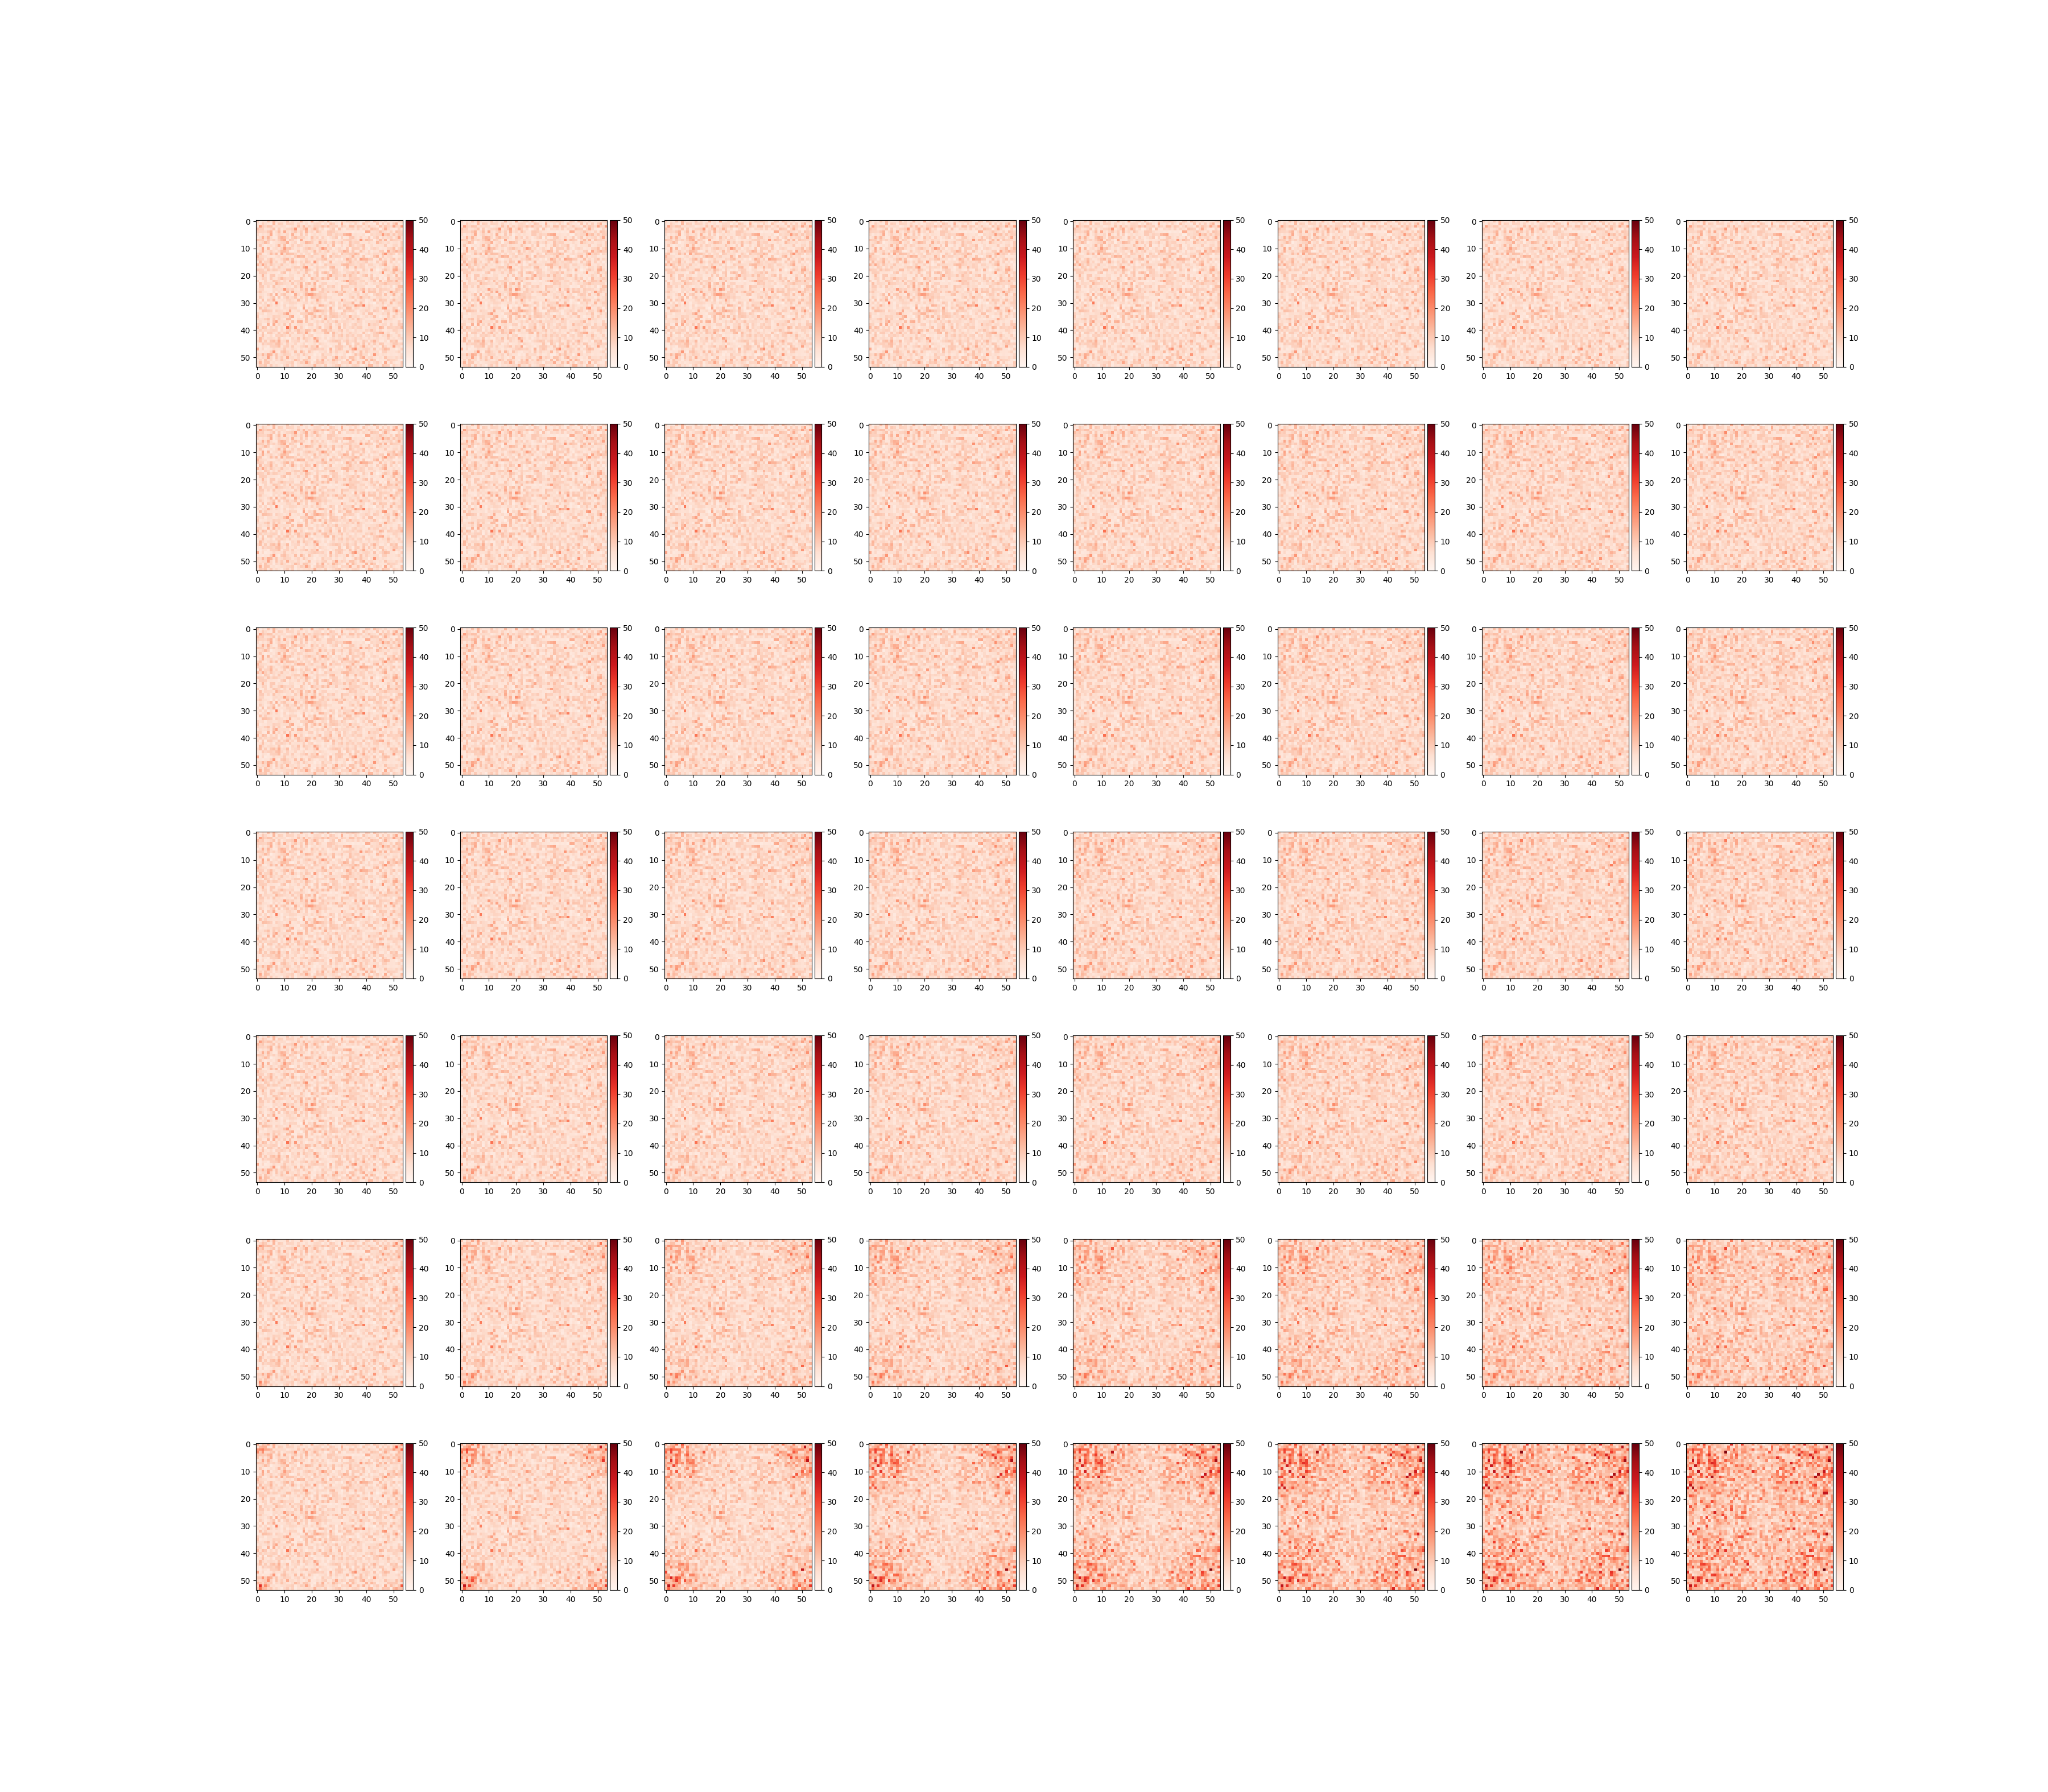

In [91]:
fig,axs = plt.subplots(len(aXs),len(rf_sizes),figsize=(4.5*len(rf_sizes),4.5*len(aXs)))
fig.subplots_adjust(hspace=0.3,wspace=0.3)

for con_idx in range(len(aXs)):
    for rf_idx in range(len(rf_sizes)):
        imshowbar(fig,axs[con_idx,rf_idx],rates[con_idx,rf_idx].reshape((net.Nrf,net.Nrf,net.NT)).mean(-1),
                  cmap='Reds',vmin=0,vmax=50)

## Perform PCA, visualize data

[0.07838985 0.01274553 0.00388525 0.00198009 0.00032974]


<IPython.core.display.Javascript object>


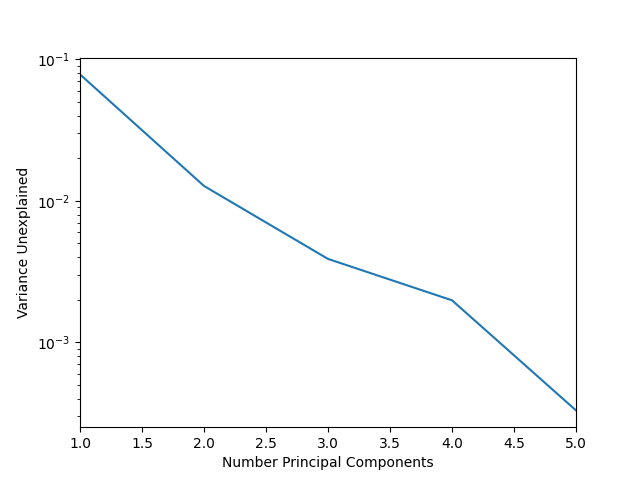

Text(0, 0.5, 'Variance Unexplained')

In [37]:
from sklearn.decomposition import PCA

X = rates.reshape((-1,net.N))
pca = PCA(n_components=5)
pca.fit(X)

print(1-np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(1,5+1),1-np.cumsum(pca.explained_variance_ratio_))
plt.xlim(1,5)
plt.yscale('log')
plt.xlabel('Number Principal Components')
plt.ylabel('Variance Unexplained')

In [72]:
X = rates.reshape((-1,net.N))
pca = PCA(n_components=3)
X_red = pca.fit_transform(X)

rates_red = X_red.reshape((len(aXs),len(rf_sizes),3))

In [73]:
# np.savetxt('rates.txt',rates.flatten())
# np.savetxt('rates_reduced.txt',rates_red.flatten())
rates = np.loadtxt('rates.txt').reshape((len(aXs),len(rf_sizes),-1))
rates_red = np.loadtxt('rates_reduced.txt').reshape((len(aXs),len(rf_sizes),-1))

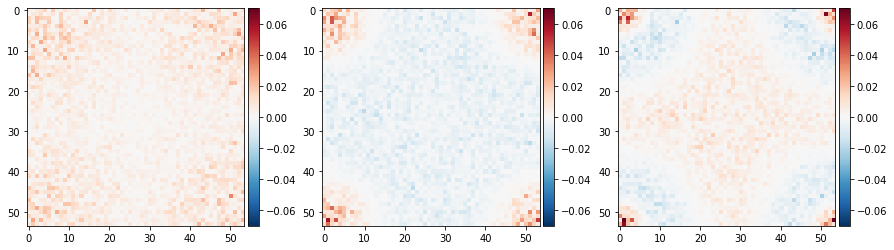

In [27]:
fig,axs = plt.subplots(1,3,figsize=(15,4))

for i in range(3):
    imshowbar(fig,axs[i],pca.components_[i].reshape((net.Nrf,net.Nrf,net.NT)).mean(-1),
              cmap='RdBu_r',vmin=-0.07,vmax=0.07)

<IPython.core.display.Javascript object>


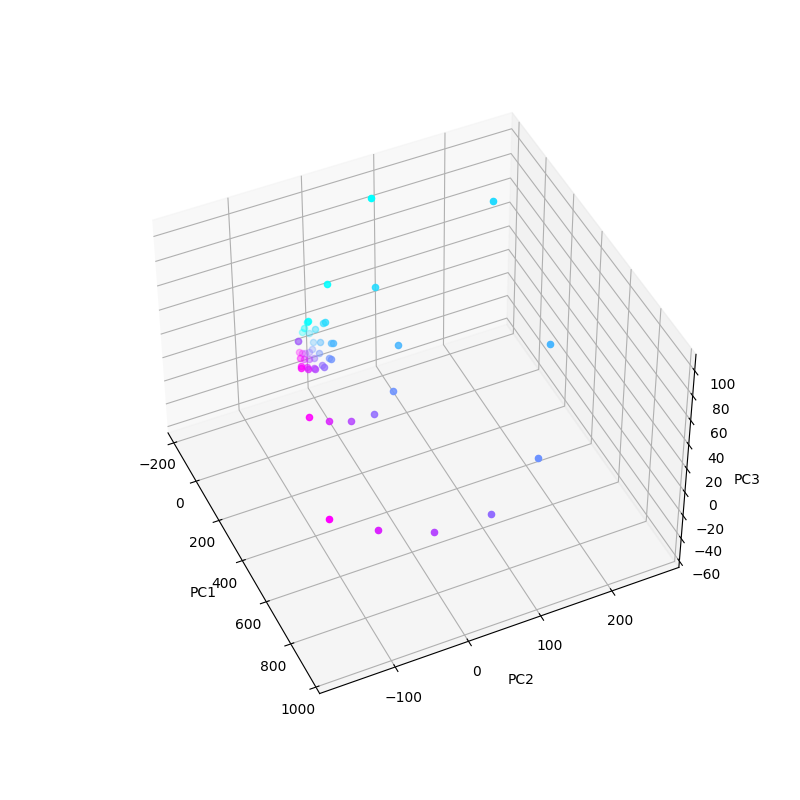

In [30]:
%matplotlib notebook

rf_cmap = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=rf_sizes[0], vmax=rf_sizes[-1]),
                            cmap=plt.get_cmap('cool'))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

for con_idx,aX in enumerate(aXs):
    alpha = (con_idx+1)/(len(aXs))
    for rf_idx,rf_size in enumerate(rf_sizes):
        color = rf_cmap.to_rgba(rf_size)
        this_rates = rates_red[con_idx,rf_idx]
        ax.scatter((this_rates[0]),(this_rates[1]),(this_rates[2]),
                    color=color,alpha=alpha)
        
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

<IPython.core.display.Javascript object>


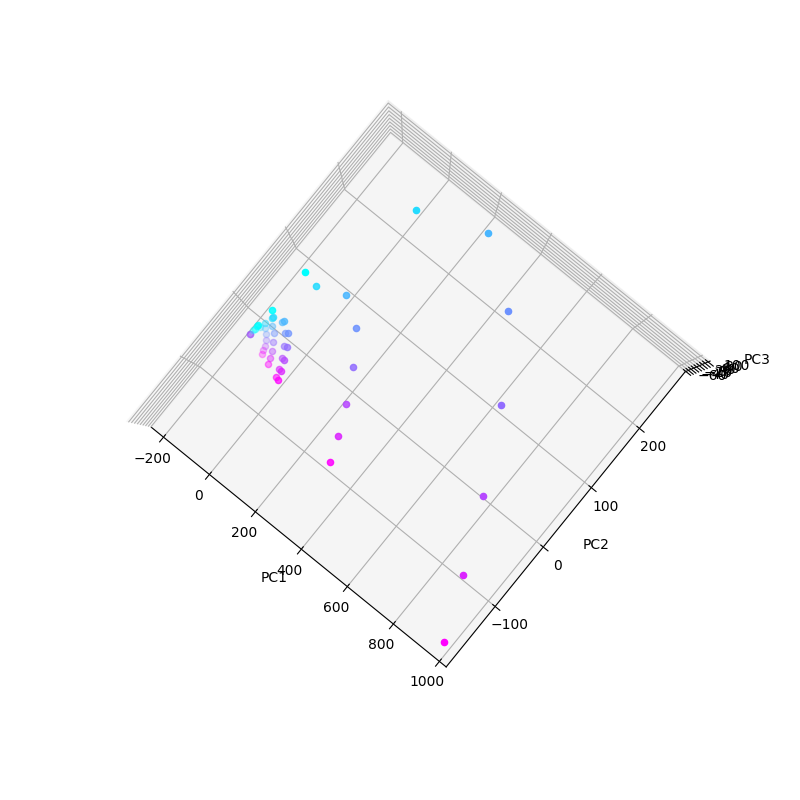

In [38]:
%matplotlib notebook

rf_cmap = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=rf_sizes[0], vmax=rf_sizes[-1]),
                            cmap=plt.get_cmap('cool'))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

for con_idx,aX in enumerate(aXs):
    alpha = (con_idx+1)/(len(aXs))
    for rf_idx,rf_size in enumerate(rf_sizes):
        color = rf_cmap.to_rgba(rf_size)
        this_rates = rates_red[con_idx,rf_idx]
        ax.scatter((this_rates[0]),(this_rates[1]),(this_rates[2]),
                    color=color,alpha=alpha)
        
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

## Compare to Gaussian with Varied Width, Height

In [56]:
N = 180
L = 90
x = np.arange(N)*L/N
x[x > L/2] = L - x[x > L/2]

In [59]:
amps = np.arange(10)
widths = np.arange(5,40+1,5)
vecs = np.zeros((len(amps),len(widths),180))
for amp_idx,amp in enumerate(amps):
    for width_idx,width in enumerate(widths):
        vecs[amp_idx,width_idx] = amp*np.exp(-x**2/(2*width**2))

[1.26061905e-01 1.97280594e-02 2.13578141e-03 7.84669836e-05
 4.85492014e-07]


<IPython.core.display.Javascript object>


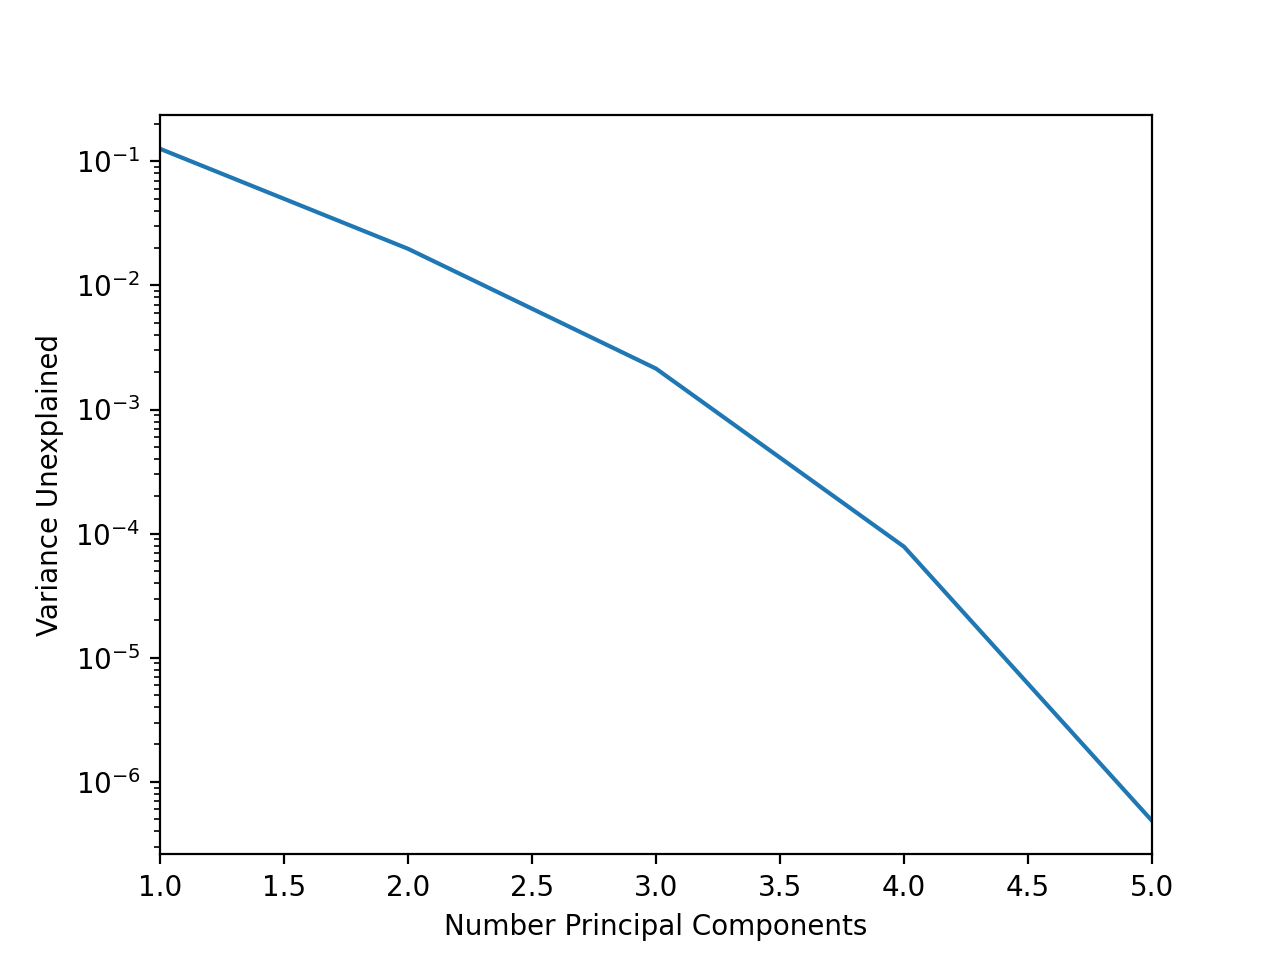

Text(0, 0.5, 'Variance Unexplained')

In [60]:
from sklearn.decomposition import PCA

X = vecs.reshape((-1,N))
pca = PCA(n_components=5)
pca.fit(X)

print(1-np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(1,5+1),1-np.cumsum(pca.explained_variance_ratio_))
plt.xlim(1,5)
plt.yscale('log')
plt.xlabel('Number Principal Components')
plt.ylabel('Variance Unexplained')

In [66]:
X = vecs.reshape((-1,N))
pca = PCA(n_components=3)
X_red = pca.fit_transform(X)

vecs_red = X_red.reshape((len(amps),len(widths),3))

<IPython.core.display.Javascript object>


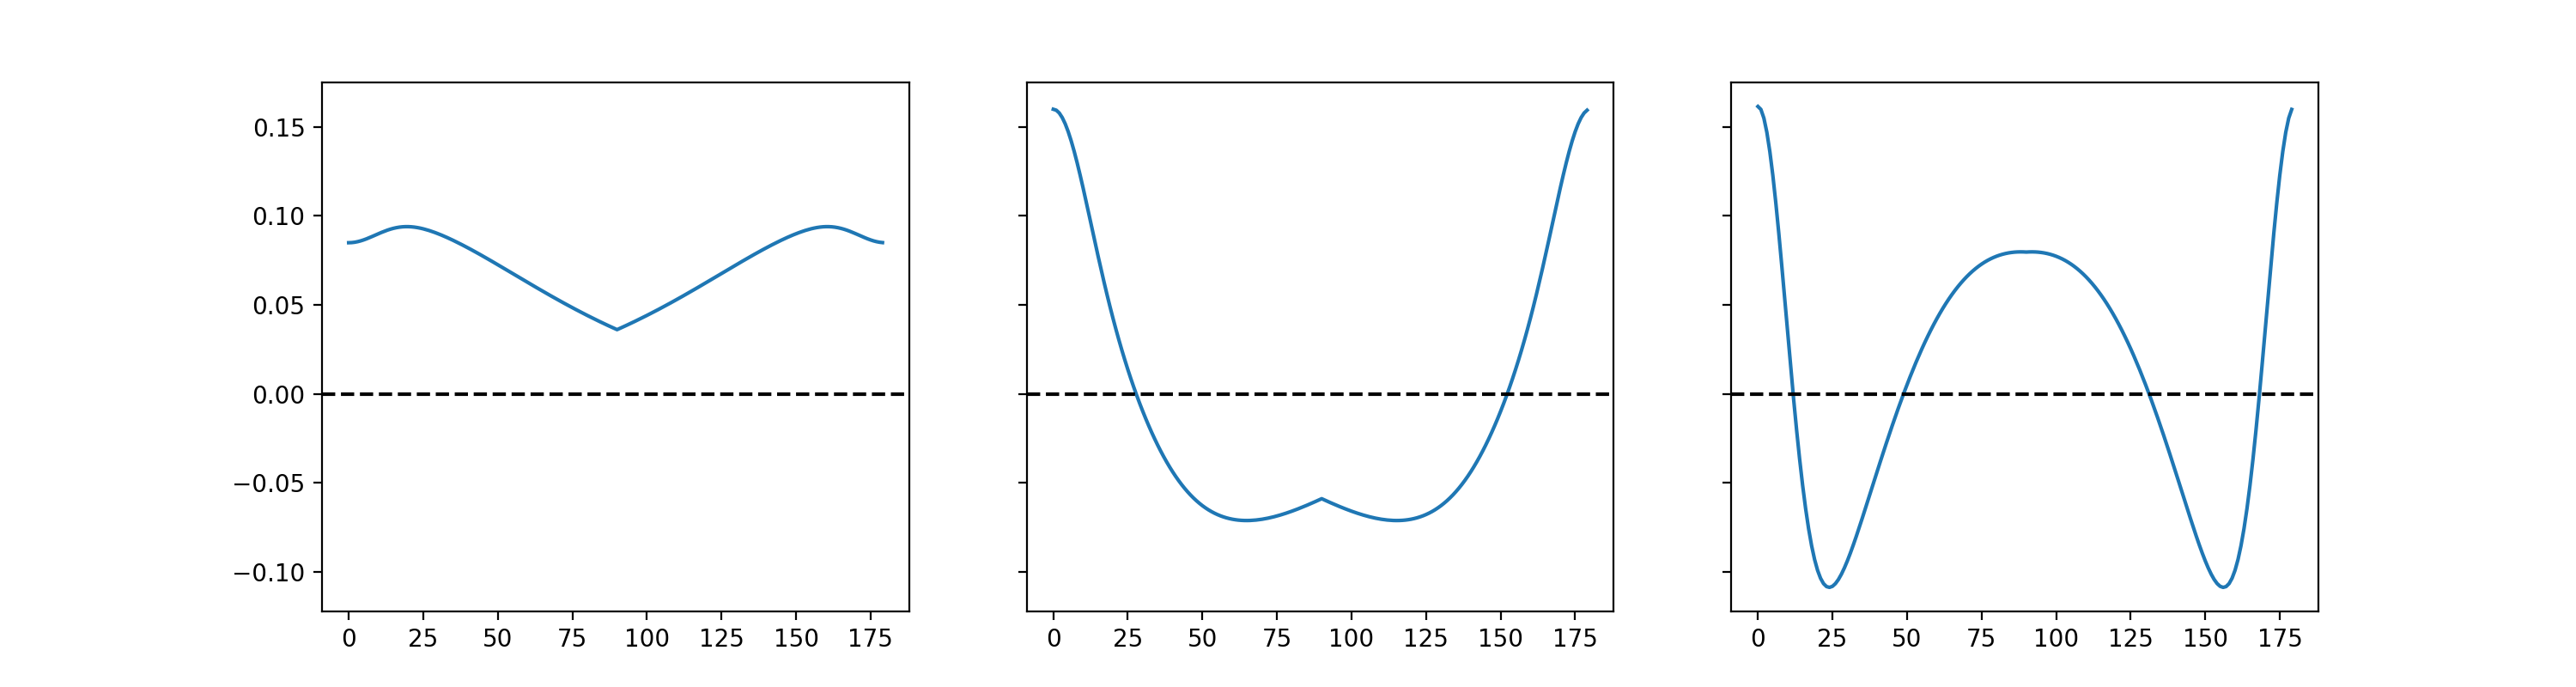

In [64]:
fig,axs = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)

for i in range(3):
    axs[i].plot(pca.components_[i])
    axs[i].axhline(0,c='k',ls='--')

<IPython.core.display.Javascript object>


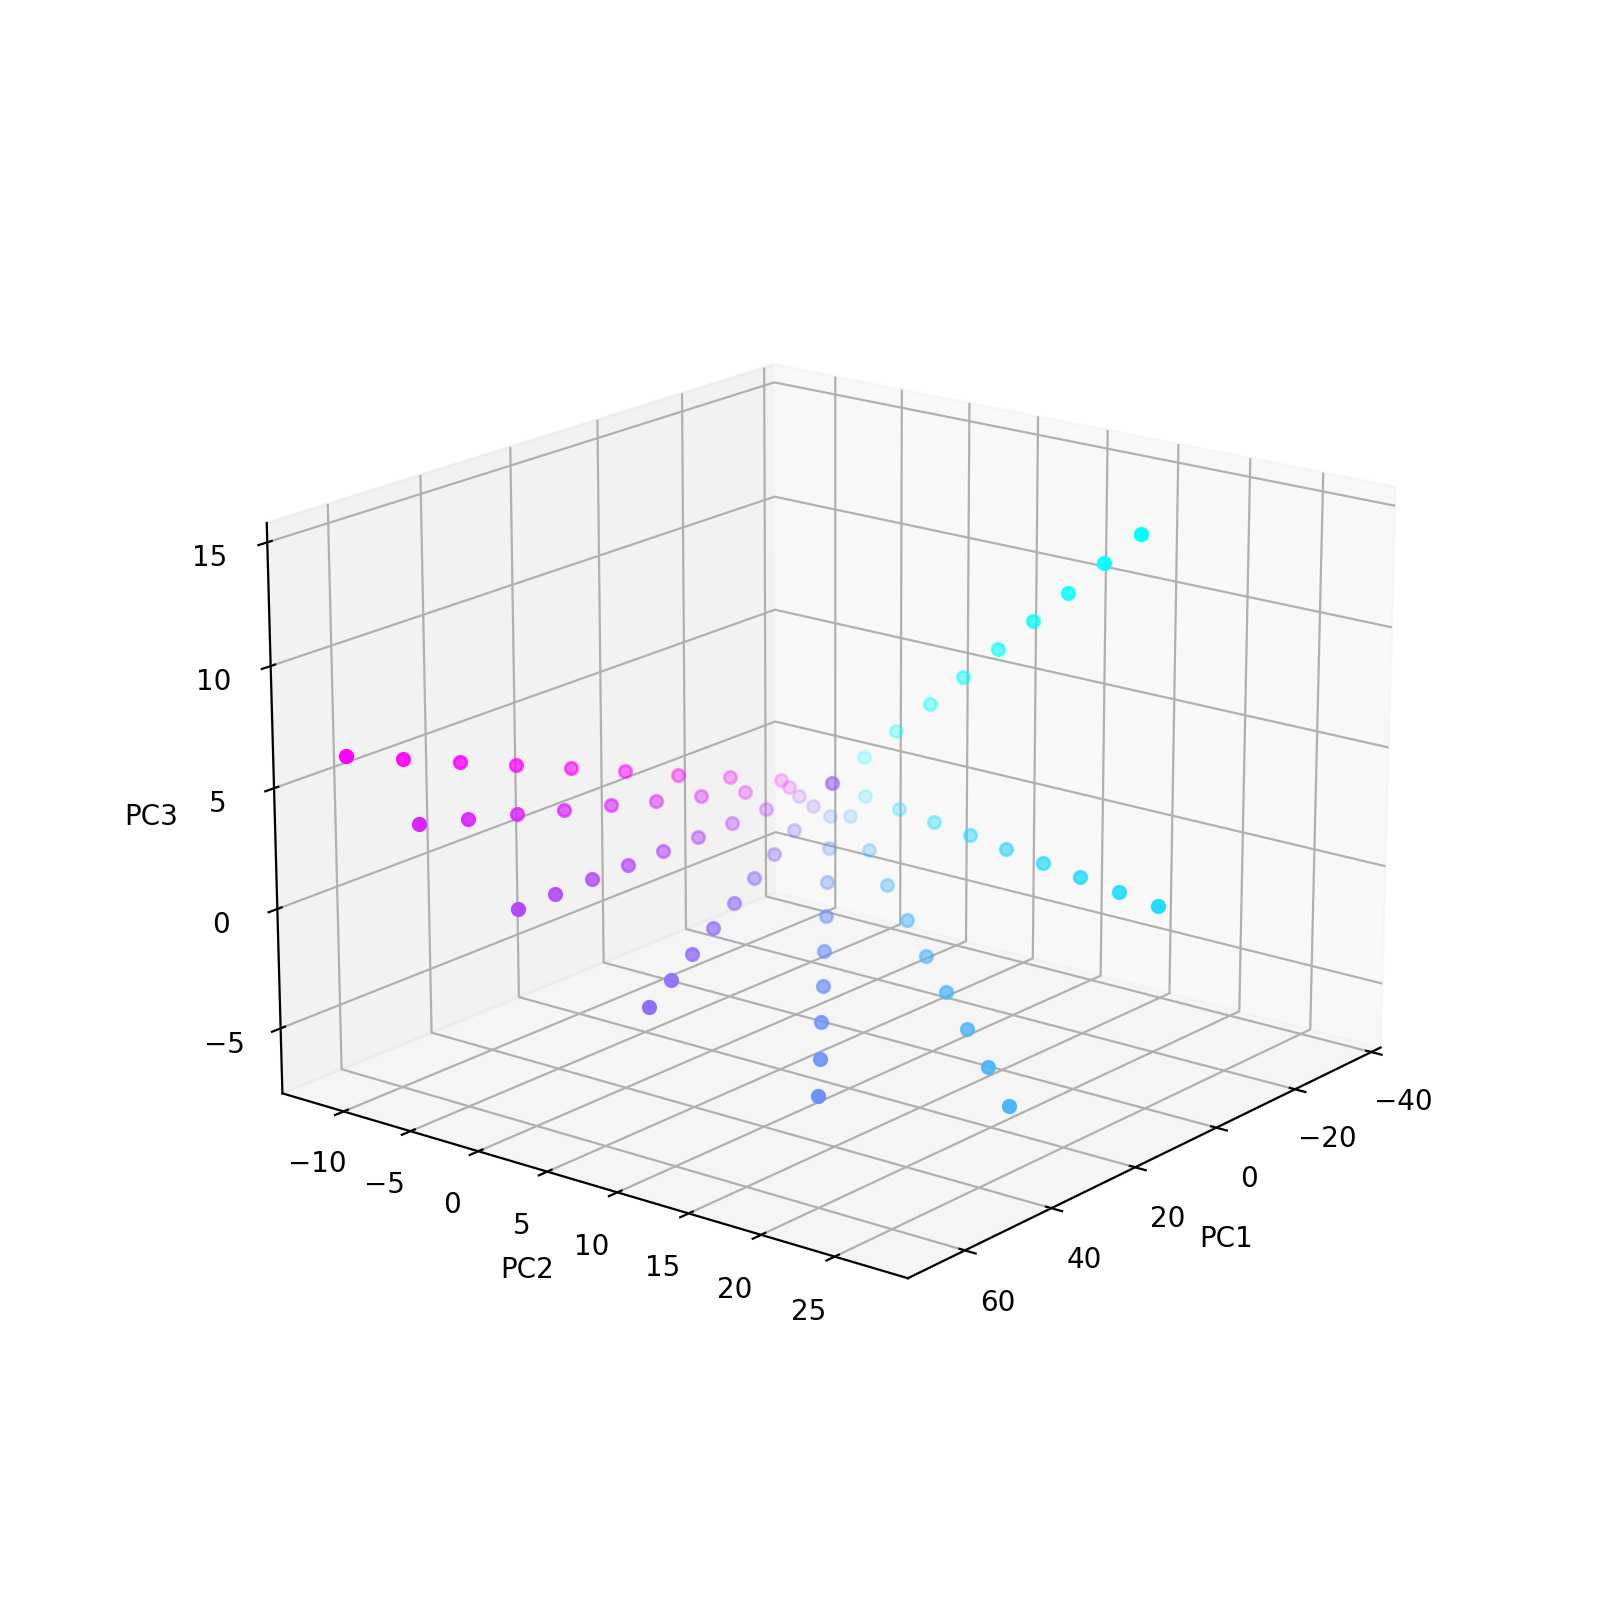

In [69]:
%matplotlib notebook

rf_cmap = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=rf_sizes[0], vmax=rf_sizes[-1]),
                            cmap=plt.get_cmap('cool'))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

for amp_idx,amp in enumerate(amps):
    alpha = (amp_idx+1)/(len(amps))
    for width_idx,width in enumerate(widths):
        color = rf_cmap.to_rgba(width)
        this_vecs = vecs_red[amp_idx,width_idx]
        ax.scatter((this_vecs[0]),(this_vecs[1]),(this_vecs[2]),
                    color=color,alpha=alpha)
        
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

plt.show()

# Vary contrast, stim size, and orientation

In [39]:
rf_sizes = np.arange(5,40+1,5)
vis_oris = np.arange(0,180,30)

In [41]:
reload(network)

net = network.SpatOriNetwork(NC=[4,1],Nrf=54,Nori=9,Lrf=90,ori_type='snp')
M = net.generate_M(W,np.array([[SrfE,SrfI],[SrfE,SrfI]]),np.array([[SoriE,SoriI],[SoriE,SoriI]]),500)
Hs = np.zeros((len(rf_sizes),len(vis_oris),net.N))
for rf_idx,rf_size in enumerate(rf_sizes):
    for ori_idx,vis_ori in enumerate(vis_oris):
        Hs[rf_idx,ori_idx] = net.generate_H(I,rf_size*np.ones(2),SoriF*np.ones(2),vis_ori=vis_ori)

shape = 1/eX**2
scale = 1/shape
eps = np.random.default_rng(0).gamma(shape,scale=scale,size=net.N)

B = np.zeros_like(Hs[0,0])
B[net.C_all[0]] = I[0]
B[net.C_all[0]] = I[1]

In [42]:
rates = np.zeros((len(aXs),len(rf_sizes),len(vis_oris),net.N))

for con_idx,aX in enumerate(aXs):
    for rf_idx in range(len(rf_sizes)):
        for ori_idx,vis_ori in enumerate(vis_oris):
            H = Hs[rf_idx,ori_idx]
            sol,_ = integ.sim_dyn(ri,T,0.0,M,(bX*B+aX*H)*eps,H,net.C_all[0],net.C_all[1],
                              mult_tau=True,max_min=30)
            rates[con_idx,rf_idx,ori_idx] = sol[:,-1]

      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after

      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after

      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after 0.19s of simulation time
      Integration stopped after

## Perform PCA, visualize data

[0.39314547 0.23203564 0.07632123 0.03136544 0.02202321]


<IPython.core.display.Javascript object>


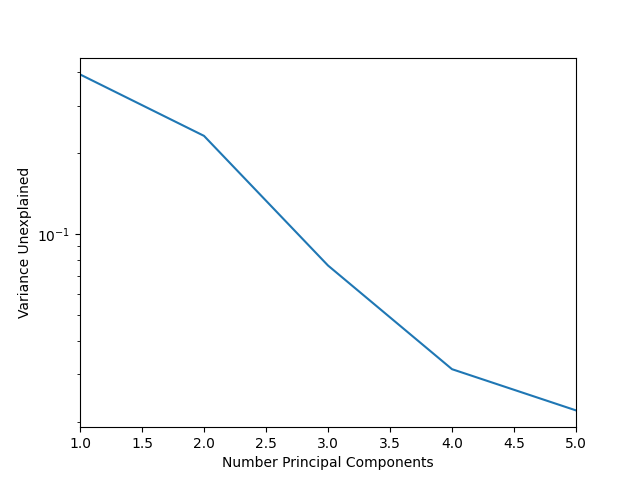

Text(0, 0.5, 'Variance Unexplained')

In [44]:
from sklearn.decomposition import PCA

X = rates.reshape((-1,net.N))
pca = PCA(n_components=5)
pca.fit(X)

print(1-np.cumsum(pca.explained_variance_ratio_))
plt.plot(np.arange(1,5+1),1-np.cumsum(pca.explained_variance_ratio_))
plt.xlim(1,5)
plt.yscale('log')
plt.xlabel('Number Principal Components')
plt.ylabel('Variance Unexplained')

In [45]:
X = rates.reshape((-1,net.N))
pca = PCA(n_components=3)
X_red = pca.fit_transform(X)

rates_red = X_red.reshape((len(aXs),len(rf_sizes),len(vis_oris),3))

In [46]:
# np.savetxt('rates_with_ori.txt',rates.flatten())
# np.savetxt('rates_with_ori_reduced.txt',rates_red.flatten())

<IPython.core.display.Javascript object>


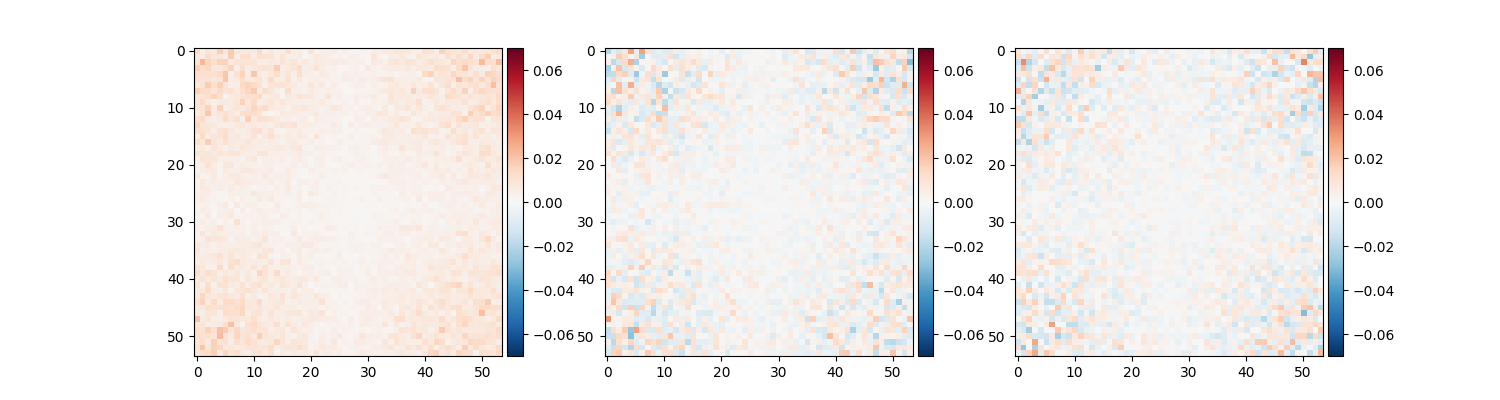

In [51]:
fig,axs = plt.subplots(1,3,figsize=(15,4))

for i in range(3):
    imshowbar(fig,axs[i],pca.components_[i].reshape((net.Nrf,net.Nrf,net.NT)).mean(-1),
              cmap='RdBu_r',vmin=-0.07,vmax=0.07)

<IPython.core.display.Javascript object>


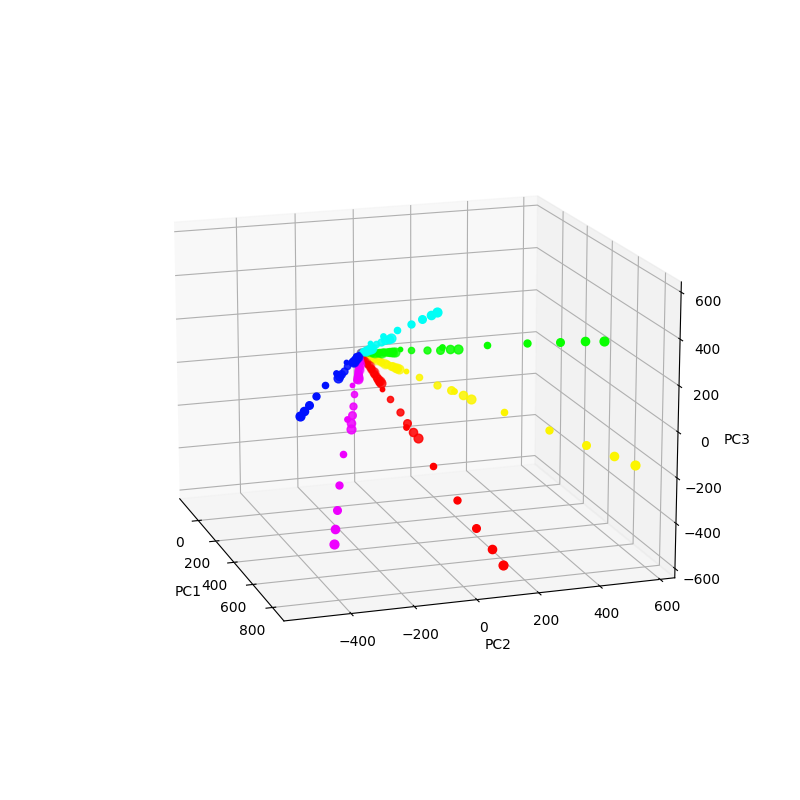

In [54]:
%matplotlib notebook

ori_cmap = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=180),
                            cmap=plt.get_cmap('hsv'))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

for con_idx,aX in enumerate(aXs):
    alpha = (con_idx+1)/(len(aXs))
    for rf_idx,rf_size in enumerate(rf_sizes):
        for ori_idx,vis_ori in enumerate(vis_oris):
            color = ori_cmap.to_rgba(vis_ori)
            this_rates = rates_red[con_idx,rf_idx,ori_idx]
            ax.scatter((this_rates[0]),(this_rates[1]),(this_rates[2]),
                        color=color,alpha=alpha,s=rf_size)
        
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
        
# widget = mpl.widgets.AxesWidget(ax)

# ax.view_init()

plt.show()

<IPython.core.display.Javascript object>


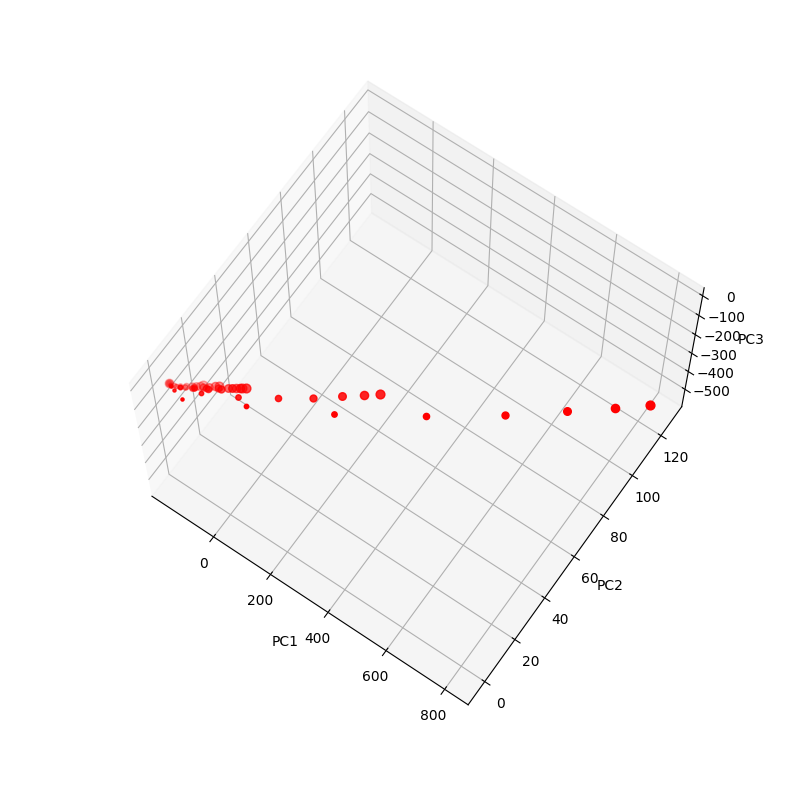

In [55]:
%matplotlib notebook

ori_cmap = cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=0, vmax=180),
                            cmap=plt.get_cmap('hsv'))

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')

for con_idx,aX in enumerate(aXs):
    alpha = (con_idx+1)/(len(aXs))
    for rf_idx,rf_size in enumerate(rf_sizes):
        for ori_idx,vis_ori in enumerate(vis_oris[0:1]):
            color = ori_cmap.to_rgba(vis_ori)
            this_rates = rates_red[con_idx,rf_idx,ori_idx]
            ax.scatter((this_rates[0]),(this_rates[1]),(this_rates[2]),
                        color=color,alpha=alpha,s=rf_size)
        
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
        
# widget = mpl.widgets.AxesWidget(ax)

# ax.view_init()

plt.show()